In [1]:
from pitas import power, flipper_tools
from orphics import maps as omaps
from pixell import enplot, enmap, curvedsky
import numpy as np
from cosmikyu import stats, mpi, datasets, config, utils, gan, transforms
import os
from itertools import product
import healpy as hp
import matplotlib.pyplot as plt
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


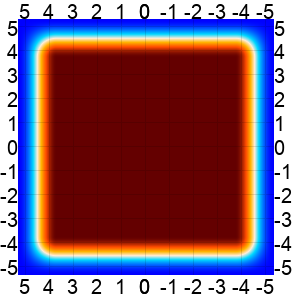

In [2]:
nside = 10
nbatch = nside*nside ## it goes like nbatch**2

shape = (128, 128)
bshape = (128*nside,128*nside)
_, bwcs = omaps.rect_geometry(width_arcmin=64.*nside, px_res_arcmin=0.5)
cuda = False

def get_template(shape, wcs):
    return enmap.zeros(shape, wcs)

def get_mask(taper_percent=15.):
    taper, _ = omaps.get_taper(bshape, taper_percent=taper_percent, pad_percent=0.)
    loc = taper == 0
    taper[loc] = np.min(taper[~loc])
    temp = get_template(bshape, bwcs)
    temp[...] = taper
    return temp

mask = get_mask()
enplot.pshow(mask, downgrade=5)

In [3]:
#bin_edges = flipper_tools.read_bin_edges("/home/dwhan89/workspace/pitas/resource/BIN_ACTPOL_50_4_SC_low_ell_startAt2")
#loc = np.where(bin_edges<8000)
#bin_edges = bin_edges[loc]
bin_edges = np.linspace(0,10000., 50)
PITAS = power.PITAS("090620_128x128taperv5", mask, mask, bin_edges=bin_edges, lmax=10000)


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mcm directory: /home/dwhan89/workspace/pitas/pitas/../output/090620_128x128taperv5
trying to load /home/dwhan89/workspace/pitas/pitas/../output/090620_128x128taperv5/curved_full_DLTT_inv.dat
[get_bbl] mcm directory: /home/dwhan89/workspace/pitas/pitas/../output/090620_128x128taperv5
trying to load /home/dwhan89/workspace/pitas/pitas/../output/090620_128x128taperv5/curved_full_BBL_DLTT.dat


In [17]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
stat_dir = os.path.join(sehgal_dir, "stats")
SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="testv3", transforms=[], dummy_label=False)
STAT_TEST = stats.STATS("sehgal_cosmoganwgpv6_test", output_dir=stat_dir, overwrite=False)

def get_data(wcs=bwcs, nside=nside, dataset=SDS_test, taper=True):
    data = SDS_test[0].copy()
    nx, ny = shape
    nshape = (data.shape[0], nx*nside, ny*nside)
    temp = enmap.zeros(nshape, wcs)
    for i in range(nside):
        for j in range(nside):
            cidx = random.randint(0, len(SDS_test)-1)
            sx = i*nx
            sy = j*ny
            temp[:,sy:sy+ny,sx:sx+nx] = SDS_test[cidx][...]
    if taper:
        temp[...] *= get_mask()
    return temp


lmax = 10000
overwrite = True
compts = ["kappa", "ksz", "tsz", "ir", "rad"]
#compts = [ "ir", "rad"]
subtasks = np.arange(300, dtype=np.int)
for sim_idx in subtasks:
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    print("processing sim {}".format(sim_idx))
    if STAT_TEST.has_data("dls_radxrad", sim_idx):
        continue
    emap = get_data()

    alms = {}
    for i, compt_idx in enumerate(compts):
        #print(i, compt_idx)
        alms[compt_idx] = curvedsky.map2alm(emap[i], lmax=lmax)
    del compt_idx

    for compt_idx1, compt_idx2 in product(compts, compts):
        compt_keys = [compt_idx1, compt_idx2]
        compt_keys.sort()
        stat_key = "dls_{}x{}".format(compt_keys[0], compt_keys[1])
        if STAT_TEST.has_data(stat_key, sim_idx):
            continue
        else:
            cl = hp.alm2cl(alms[compt_idx1], alms[compt_idx2])
            l = np.arange(len(cl), dtype=np.float)
            dl = l*(l+1.)/(2*np.pi)*cl
            lbin, dlbin = PITAS.binner.bin(l, dl)
            dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)
            STAT_TEST.add_data("lbin", 0, lbin)
            STAT_TEST.add_data(stat_key, sim_idx, dlbin)

    #del alms

_ = STAT_TEST.get_stats(save_data=True)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_sehgal_cosmoganwgpv6_test.npz
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4
processing sim 5
processing sim 6
processing sim 7
processing sim 8
processing sim 9
processing sim 10
processing sim 11
processing sim 12
processing sim 13
processing sim 14
processing sim 15
processing sim 16
processing sim 17
processing sim 18
processing sim 19
processing sim 20
processing sim 21
processing sim 22
processing sim 23
processing sim 24
processing sim 25
processing sim 26
processing sim 27
processing sim 28
processing sim 29
processing sim 30
processing sim 31
processing sim 32
processing sim 33
processing sim 34
processing sim 35
processing sim 36
processing sim 37
processing sim 38
processing sim 39
processing sim 40
processing sim 41
processing sim 42
processing sim 43
processing sim 44
p

/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov      = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [24]:

clamp_info = utils.load_data("/home/dwhan89/workspace/cosmikyu/data/sehgal/clamp_info_modelv6.npz")
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
tanh_settings = [None]*len(compts)
for i, comp_idx in enumerate(compts):
    setting = clamp_info[comp_idx]["minval"], clamp_info[comp_idx]["maxval"]
    tanh_settings[i] = setting

MHTanh = gan.MultiHardTanh(tanh_settings)
SAL = gan.SehgalActivationLayer(tanh_settings)
STanh = gan.ScaledTanh(15., 2./15.)


#norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/normalization_info_fullv3.npz"
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/082520_normalization_info_model.npz"
experiment_id = "6c542f37a11b42908fa8f84c57c681f7"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_090420/{}/model".format(experiment_id)
print(model_dir)
latent_dim = 256
overwrite =False
#SDUN = transforms.SehgalDataUnnormalizer(norm_info_file, zfact=4)
SDN = transforms.SehgalDataNormalizerScaledLogZ(norm_info_file)
SDUN = transforms.SehgalDataUnnormalizerScaledLogZ(norm_info_file)
#STAT = stats.STATS("sehgal_cosmoganwgpv4_generated", output_dir=stat_dir, overwrite=False)
STAT_GEN = stats.STATS(experiment_id, output_dir=stat_dir, overwrite=overwrite)
#compts = ["kappa", "ksz", "tsz", "ir", "rad"]
save_points = [100]
nsim = 100

for save_point in save_points: 
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    DCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", (5,)+shape, latent_dim, cuda=False, nconv_fcgen=64,
                                  nconv_fcdis=64, ngpu=4, nconv_layer_gen=5, nconv_layer_disc=5, kernal_size=5, stride=2,
                                                            padding=2, output_padding=1, gen_act=STanh)

    DCGAN_WGP.load_states(model_dir, "_{}".format(save_point))
    
    def get_generated(wcs=bwcs, nside=nside, gan=DCGAN_WGP, taper=True):
        shape = gan.shape
        nx, ny = shape[1], shape[2]
        nshape = (shape[0], shape[1]*nside, shape[2]*nside)
        temp = enmap.zeros(nshape, wcs)
        np.random.seed(None)
        generated = gan.generate_samples(nside*nside).data.numpy()
        #ctr = 0
        for i in range(nside):
            for j in range(nside):
                ctr = i*nside+j
                sx = i*nx
                sy = j*ny
                temp[:,sy:sy+ny,sx:sx+nx] = SDUN(generated[ctr])
        if taper:
            temp[...] *= get_mask()
        return temp
    
    subtasks = np.arange(nsim, dtype=np.int)
    for sim_idx in subtasks:
        emap = get_generated()
        #enplot.pshow(emap)
        stat_key = "dls_radxrad_r{}".format(save_point)
        if STAT_GEN.has_data(stat_key, sim_idx):
            continue
        alms = {}
        for i, compt_idx in enumerate(compts):
            #i += 3
            print(i, compt_idx)
            alms[compt_idx] = curvedsky.map2alm(emap[i], lmax=lmax)
        del compt_idx
        
        for compt_idx1, compt_idx2 in product(compts, compts):
            compt_keys = [compt_idx1, compt_idx2]
            compt_keys.sort()
            stat_key = "dls_{}x{}_r{}".format(compt_keys[0], compt_keys[1],save_point)
            print(stat_key)
            if STAT_GEN.has_data(stat_key, sim_idx):
                continue
            else:
                cl = hp.alm2cl(alms[compt_idx1], alms[compt_idx2])
                l = np.arange(len(cl), dtype=np.float)
                dl = l*(l+1.)/(2*np.pi)*cl
                lbin, dlbin = PITAS.binner.bin(l, dl)
                dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)
                STAT_GEN.add_data("lbin", 0, lbin)
                STAT_GEN.add_data(stat_key, sim_idx, dlbin)

        #del alms
_ = STAT_GEN.get_stats(save_data=True)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.M

/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_090420/6c542f37a11b42908fa8f84c57c681f7/model
[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_6c542f37a11b42908fa8f84c57c681f7.npz
[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _100
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r100
dls_kappaxksz_r100
dls_kappaxtsz_r100
dls_irxkappa_r100
dls_kappaxrad_r100
dls_kappaxksz_r100
dls_kszxksz_r100
dls_kszxtsz_r100
dls_irxksz_r100
dls_kszxrad_r100
dls_kappaxtsz_r100
dls_kszxtsz_r100
dls_tszxtsz_r100
dls_irxtsz_r100
dls_radxtsz_r100
dls_irxkappa_r100
dls_irxksz_r100
dls_irxtsz_r100
dls_irxir_r100
dls_irxrad_r100
dls_kappaxrad_r100
dls_kszxrad_r100
dls_radxtsz_r100
dls_irxrad_r100
dls_radxrad_r100
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r100
dls_kappaxksz_r100
dls_kappaxtsz_r100
dls_irxkappa_r100
dls_kappaxrad_r

dls_irxrad_r100
dls_kappaxrad_r100
dls_kszxrad_r100
dls_radxtsz_r100
dls_irxrad_r100
dls_radxrad_r100
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r100
dls_kappaxksz_r100
dls_kappaxtsz_r100
dls_irxkappa_r100
dls_kappaxrad_r100
dls_kappaxksz_r100
dls_kszxksz_r100
dls_kszxtsz_r100
dls_irxksz_r100
dls_kszxrad_r100
dls_kappaxtsz_r100
dls_kszxtsz_r100
dls_tszxtsz_r100
dls_irxtsz_r100
dls_radxtsz_r100
dls_irxkappa_r100
dls_irxksz_r100
dls_irxtsz_r100
dls_irxir_r100
dls_irxrad_r100
dls_kappaxrad_r100
dls_kszxrad_r100
dls_radxtsz_r100
dls_irxrad_r100
dls_radxrad_r100
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r100
dls_kappaxksz_r100
dls_kappaxtsz_r100
dls_irxkappa_r100
dls_kappaxrad_r100
dls_kappaxksz_r100
dls_kszxksz_r100
dls_kszxtsz_r100
dls_irxksz_r100
dls_kszxrad_r100
dls_kappaxtsz_r100
dls_kszxtsz_r100
dls_tszxtsz_r100
dls_irxtsz_r100
dls_radxtsz_r100
dls_irxkappa_r100
dls_irxksz_r100
dls_irxtsz_r100
dls_irxir_r100
dls_irxrad_r100
dls_kappaxrad_r100
dls_kszxrad_r100
dls_radxtsz_r100

dls_irxksz_r100
dls_kszxrad_r100
dls_kappaxtsz_r100
dls_kszxtsz_r100
dls_tszxtsz_r100
dls_irxtsz_r100
dls_radxtsz_r100
dls_irxkappa_r100
dls_irxksz_r100
dls_irxtsz_r100
dls_irxir_r100
dls_irxrad_r100
dls_kappaxrad_r100
dls_kszxrad_r100
dls_radxtsz_r100
dls_irxrad_r100
dls_radxrad_r100
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r100
dls_kappaxksz_r100
dls_kappaxtsz_r100
dls_irxkappa_r100
dls_kappaxrad_r100
dls_kappaxksz_r100
dls_kszxksz_r100
dls_kszxtsz_r100
dls_irxksz_r100
dls_kszxrad_r100
dls_kappaxtsz_r100
dls_kszxtsz_r100
dls_tszxtsz_r100
dls_irxtsz_r100
dls_radxtsz_r100
dls_irxkappa_r100
dls_irxksz_r100
dls_irxtsz_r100
dls_irxir_r100
dls_irxrad_r100
dls_kappaxrad_r100
dls_kszxrad_r100
dls_radxtsz_r100
dls_irxrad_r100
dls_radxrad_r100
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r100
dls_kappaxksz_r100
dls_kappaxtsz_r100
dls_irxkappa_r100
dls_kappaxrad_r100
dls_kappaxksz_r100
dls_kszxksz_r100
dls_kszxtsz_r100
dls_irxksz_r100
dls_kszxrad_r100
dls_kappaxtsz_r100
dls_kszxtsz_r100

0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r100
dls_kappaxksz_r100
dls_kappaxtsz_r100
dls_irxkappa_r100
dls_kappaxrad_r100
dls_kappaxksz_r100
dls_kszxksz_r100
dls_kszxtsz_r100
dls_irxksz_r100
dls_kszxrad_r100
dls_kappaxtsz_r100
dls_kszxtsz_r100
dls_tszxtsz_r100
dls_irxtsz_r100
dls_radxtsz_r100
dls_irxkappa_r100
dls_irxksz_r100
dls_irxtsz_r100
dls_irxir_r100
dls_irxrad_r100
dls_kappaxrad_r100
dls_kszxrad_r100
dls_radxtsz_r100
dls_irxrad_r100
dls_radxrad_r100
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r100
dls_kappaxksz_r100
dls_kappaxtsz_r100
dls_irxkappa_r100
dls_kappaxrad_r100
dls_kappaxksz_r100
dls_kszxksz_r100
dls_kszxtsz_r100
dls_irxksz_r100
dls_kszxrad_r100
dls_kappaxtsz_r100
dls_kszxtsz_r100
dls_tszxtsz_r100
dls_irxtsz_r100
dls_radxtsz_r100
dls_irxkappa_r100
dls_irxksz_r100
dls_irxtsz_r100
dls_irxir_r100
dls_irxrad_r100
dls_kappaxrad_r100
dls_kszxrad_r100
dls_radxtsz_r100
dls_irxrad_r100
dls_radxrad_r100
0 kappa
1 ksz
2 tsz
3 ir
4 rad
dls_kappaxkappa_r100
dls_kappaxksz_r1

dls_radxtsz_r100
dls_irxkappa_r100
dls_irxksz_r100
dls_irxtsz_r100
dls_irxir_r100
dls_irxrad_r100
dls_kappaxrad_r100
dls_kszxrad_r100
dls_radxtsz_r100
dls_irxrad_r100
dls_radxrad_r100
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_6c542f37a11b42908fa8f84c57c681f7.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_6c542f37a11b42908fa8f84c57c681f7.npz
calculating stats


/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov      = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [25]:
STAT_GEN_CORR = stats.STATS("sehgal_cosmoganwgpv6_gen_corr", output_dir=stat_dir, overwrite=True)
for st_key in STAT_GEN.storage:
    if st_key == "lbin": 
        STAT_GEN_CORR.add_data("lbin", 0, STAT_GEN.storage["lbin"][0])
        continue
    ost_key = "_".join(st_key.split("_")[:2])
    nst_key = st_key 
    transf = STAT_TEST.stats[ost_key]["mean"]/STAT_GEN.stats[st_key]["mean"]
    for sim_idx in STAT_GEN.storage[st_key]:
        STAT_GEN_CORR.add_data(nst_key, sim_idx, STAT_GEN.storage[st_key][sim_idx]*transf)
        
STAT_GEN_CORR.get_stats(save_data=False)

        

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
calculating stats


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'lbin': {'mean': array([ 103. ,  306.5,  510.5,  714.5,  918.5, 1122.5, 1326.5, 1530.5,
         1734.5, 1938.5, 2142.5, 2346.5, 2551. , 2755.5, 2959.5, 3163.5,
         3367.5, 3571.5, 3775.5, 3979.5, 4183.5, 4387.5, 4591.5, 4795.5,
         5000. , 5204.5, 5408.5, 5612.5, 5816.5, 6020.5, 6224.5, 6428.5,
         6632.5, 6836.5, 7040.5, 7244.5, 7449. , 7653.5, 7857.5, 8061.5,
         8265.5, 8469.5, 8673.5, 8877.5, 9081.5, 9285.5, 9489.5, 9693.5,
         9898. ]),
  'cov': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'corrcoef': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

<Figure size 432x288 with 0 Axes>

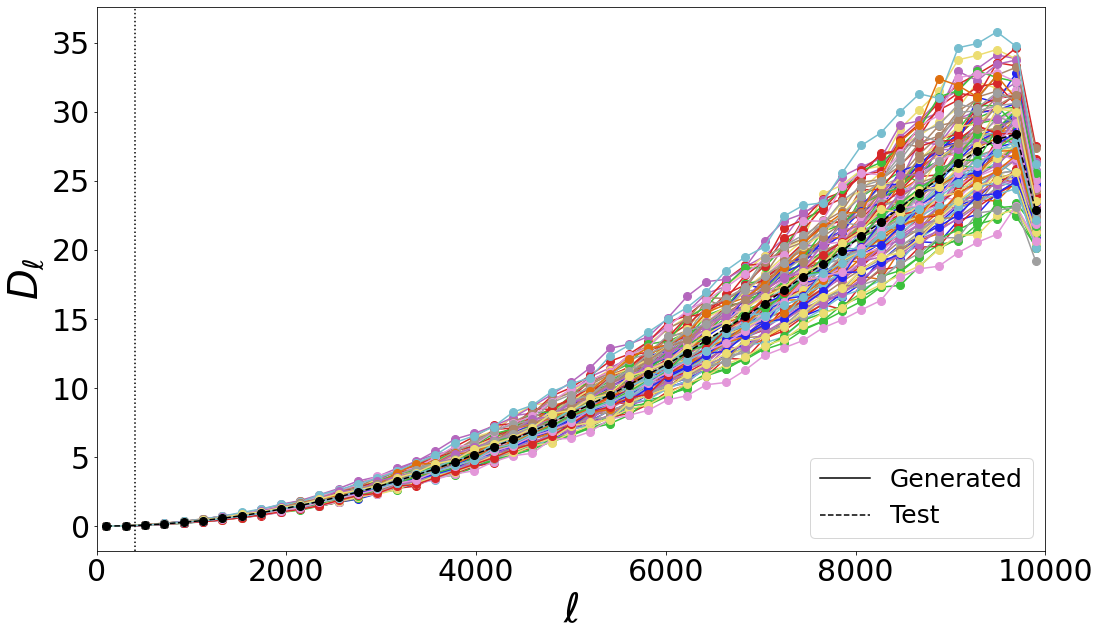

In [26]:
plt.clf()
compts = ["rad"]
for key1 in compts:
    fig = plt.figure(figsize=(17,10))
    ax = fig.gca()
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
   
    
    for save_point in save_points:#,20]:
        for sim_idx in range(nsim):
            skey = key + "_r" + str(save_point)
            lbin = STAT_GEN_CORR.storage["lbin"][0].copy()
            dlbin = STAT_GEN_CORR.storage[skey][sim_idx].copy()
            #std = STAT_GEN.stats[skey]["std"].copy()
            #print(std)
            plt.plot(lbin, dlbin,  marker="o",markersize=8)
    
    lbin = STAT_TEST.storage["lbin"][0].copy()
    dlbin = STAT_TEST.stats[key]["mean"].copy()
    std = STAT_TEST.stats[key]["std"].copy()
    plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color="k", ls="--")
    #plt.plot(l, dls, alpha=0.3, label=key, ls="", marker="o", markersize=4)
    #plt.plot([],[], label=key, color=color)
    plt.plot([],[], ls="-",label="Generated", color="k")
    plt.plot([],[], ls="--",label="Test", color="k")
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$D_\ell$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.legend(fontsize=25)
    #plt.ylim(1e-7,2e3)
    plt.axvline(x=400, ls=":", color="k")
    plt.xlim(0,10000)
    #plt.yscale("log")
    plt.show()

[2.59481242e-05 6.49412592e-05 8.25585243e-05 8.36388685e-05
 8.52136452e-05 8.55947568e-05 7.05430877e-05 6.98151439e-05
 7.21882498e-05 7.51677002e-05 6.64310148e-05 7.03186755e-05
 6.70890831e-05 6.62718396e-05 7.25259693e-05 6.70747111e-05
 7.00642861e-05 7.12379664e-05 6.76428415e-05 7.04522834e-05
 6.16366574e-05 6.12506489e-05 6.82480264e-05 5.69502863e-05
 6.88234337e-05 6.98275095e-05 5.94246799e-05 5.96217819e-05
 5.92820822e-05 5.66950520e-05 5.86265692e-05 6.14284159e-05
 5.52221277e-05 6.21656398e-05 5.74897784e-05 5.78890080e-05
 5.70236183e-05 5.25040637e-05 6.15778185e-05 4.99098295e-05
 5.01358777e-05 4.67602624e-05 4.73666833e-05 4.60625567e-05
 4.83820356e-05 4.79394239e-05 4.21126577e-05 4.48808250e-05
 3.25326227e-05]


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 432x288 with 0 Axes>

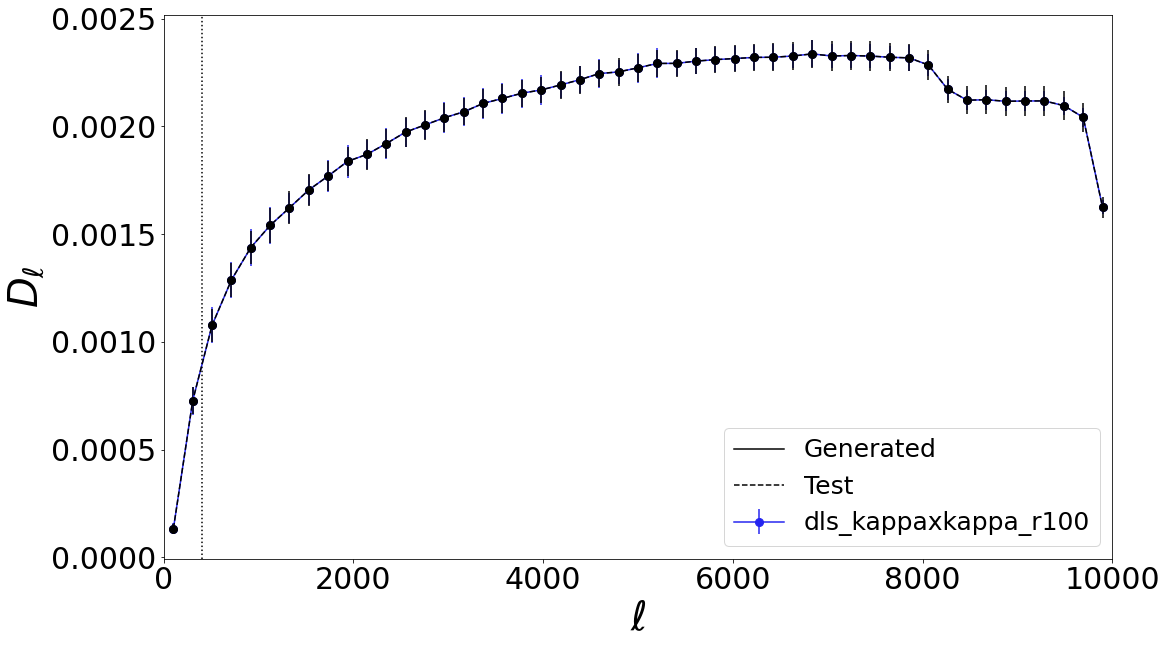

[0.01064057 0.04809995 0.0502598  0.06490039 0.08701432 0.08576231
 0.08772103 0.07997574 0.07941757 0.08150647 0.08113753 0.07506103
 0.07873166 0.07129391 0.07587333 0.07421157 0.06471898 0.07187486
 0.06339681 0.06967067 0.06956749 0.0718964  0.07108792 0.06067732
 0.06381854 0.06129218 0.05749327 0.0642355  0.05820092 0.05956747
 0.06081278 0.05733447 0.04771476 0.05585277 0.04982308 0.05543541
 0.05112911 0.04578803 0.05078396 0.05370901 0.05171155 0.04710842
 0.0557037  0.0429643  0.04793013 0.03948785 0.04166813 0.0435597
 0.0321295 ]


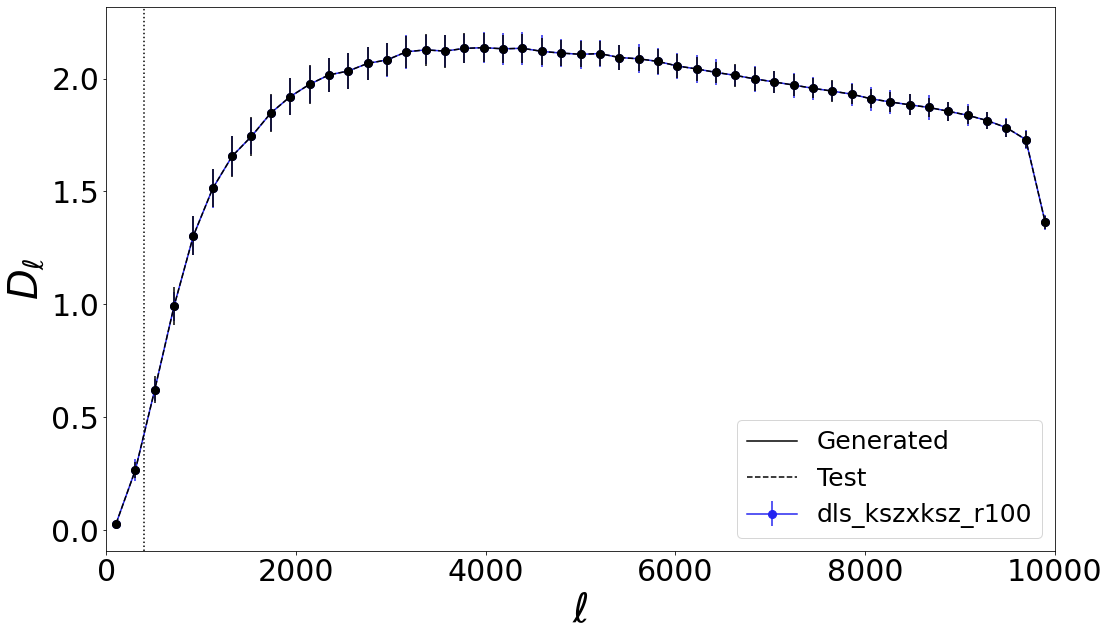

[0.94394692 1.70426132 2.16133852 1.42999906 1.0250084  0.89454953
 0.74375408 0.67673197 0.60488291 0.55518254 0.49137437 0.43810314
 0.40022373 0.3624161  0.32843104 0.31289051 0.29813616 0.2843443
 0.24917895 0.24337733 0.22563104 0.21983792 0.21000125 0.19482864
 0.19388686 0.1879012  0.18048571 0.18116143 0.17303846 0.16615159
 0.16678517 0.16291615 0.15895474 0.1618309  0.1568283  0.14724253
 0.1490314  0.13193654 0.14190167 0.12711439 0.12429564 0.11390269
 0.11787435 0.10504551 0.09648327 0.08627189 0.08272005 0.08144982
 0.06428259]


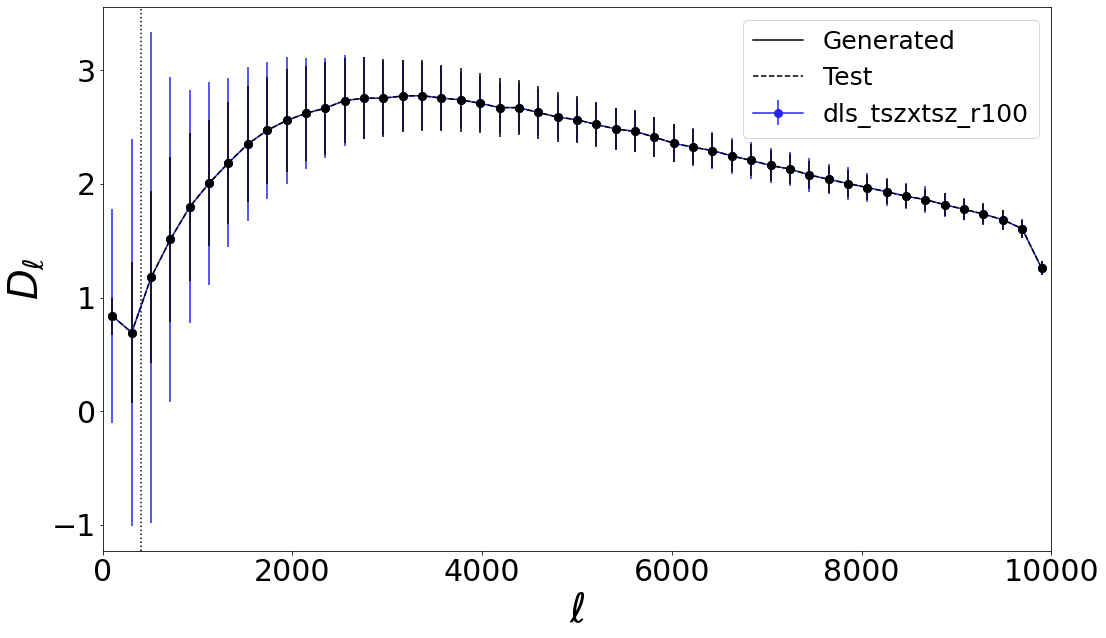

[1.07163487e-03 4.96546435e-03 1.07533845e-02 1.86457889e-02
 3.23251787e-02 4.86647089e-02 6.66554209e-02 8.51796668e-02
 1.06382095e-01 1.33194174e-01 1.55547006e-01 1.94077576e-01
 2.31759764e-01 2.73695253e-01 3.07304534e-01 3.54673309e-01
 4.20274557e-01 4.51032266e-01 5.28607054e-01 5.68073027e-01
 6.38104517e-01 7.03140427e-01 7.83807047e-01 8.41245041e-01
 8.99512231e-01 9.93172120e-01 1.09975973e+00 1.16490192e+00
 1.24530687e+00 1.37684861e+00 1.48424577e+00 1.60979290e+00
 1.66384200e+00 1.79082812e+00 1.86172789e+00 2.07925542e+00
 2.15267281e+00 2.26104550e+00 2.41823276e+00 2.56930738e+00
 2.56599267e+00 2.77839181e+00 2.86207451e+00 2.96477675e+00
 3.11518021e+00 3.10818408e+00 3.00652708e+00 2.83886518e+00
 1.78066685e+00]


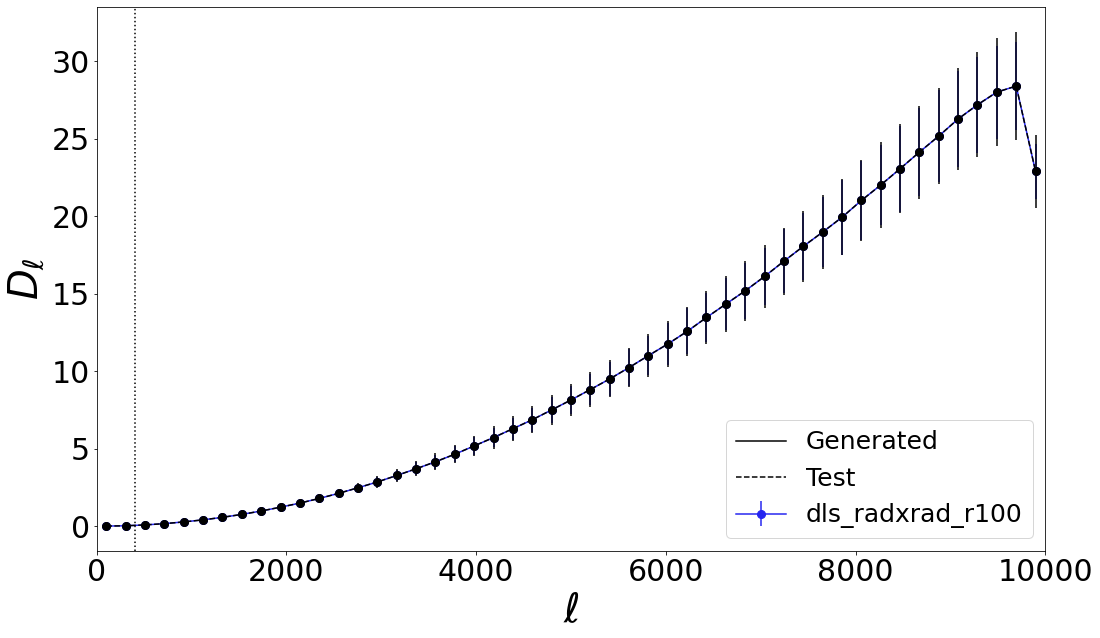

[0.48518999 0.27430007 0.19176277 0.20788559 0.18403836 0.214871
 0.23820256 0.25948813 0.28521772 0.33022973 0.37712375 0.41855171
 0.45125358 0.4127214  0.54425216 0.52462605 0.51608357 0.57809276
 0.66985067 0.63058667 0.80610223 0.78357402 0.91185048 0.87648041
 1.05333977 1.03260441 1.03661862 1.09786994 1.10236352 1.18735262
 1.31647654 1.532537   1.41626313 1.64570466 1.74199276 1.89620331
 1.96973849 2.12489913 2.25921791 2.15079933 2.56926503 2.63098561
 3.20887807 3.00531835 3.17232033 2.89873147 3.1577459  3.03126299
 3.38132638]


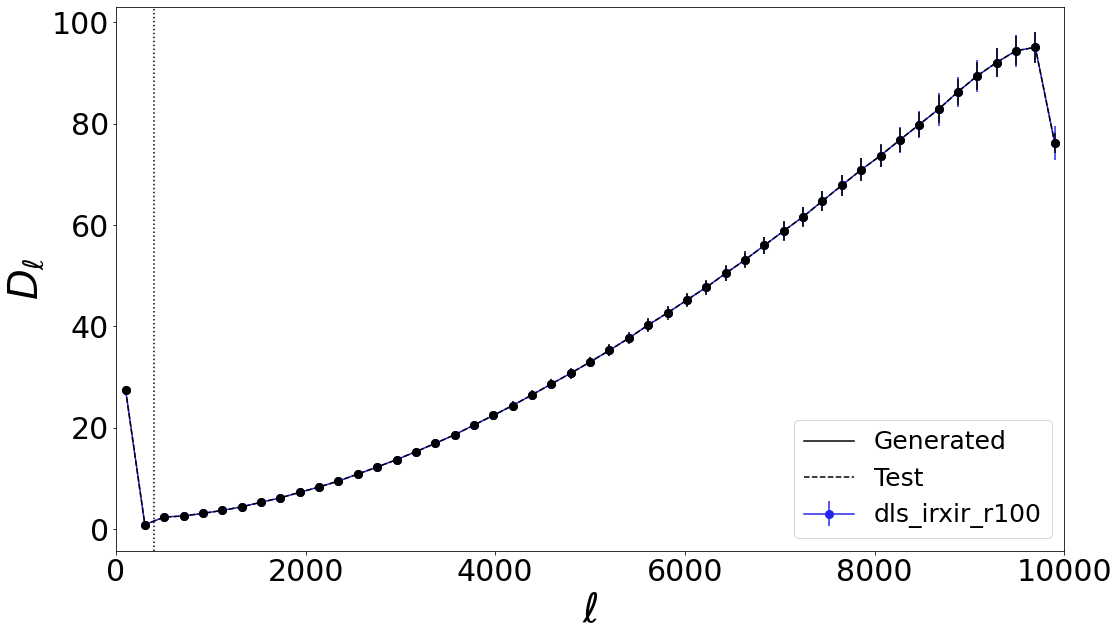

In [27]:
plt.clf()
compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for key1 in compts:
    fig = plt.figure(figsize=(17,10))
    ax = fig.gca()
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
   
    
    for save_point in save_points[-2:]:#,20]:
        skey = key + "_r" + str(save_point)
        lbin = STAT_GEN_CORR.storage["lbin"][0].copy()
        dlbin = STAT_GEN_CORR.stats[skey]["mean"].copy()
        std = STAT_GEN_CORR.stats[skey]["std"].copy()
        print(std)
        plt.errorbar(lbin, dlbin, std,  marker="o",markersize=8, label=skey)
    
    lbin = STAT_TEST.storage["lbin"][0].copy()
    dlbin = STAT_TEST.stats[key]["mean"].copy()
    std = STAT_TEST.stats[key]["std"].copy()
    plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color="k", ls="--")
    #plt.plot(l, dls, alpha=0.3, label=key, ls="", marker="o", markersize=4)
    #plt.plot([],[], label=key, color=color)
    plt.plot([],[], ls="-",label="Generated", color="k")
    plt.plot([],[], ls="--",label="Test", color="k")
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$D_\ell$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.legend(fontsize=25)
    #plt.ylim(1e-7,2e3)
    plt.axvline(x=400, ls=":", color="k")
    plt.xlim(0,10000)
    #plt.yscale("log")
    plt.show()

<Figure size 432x288 with 0 Axes>

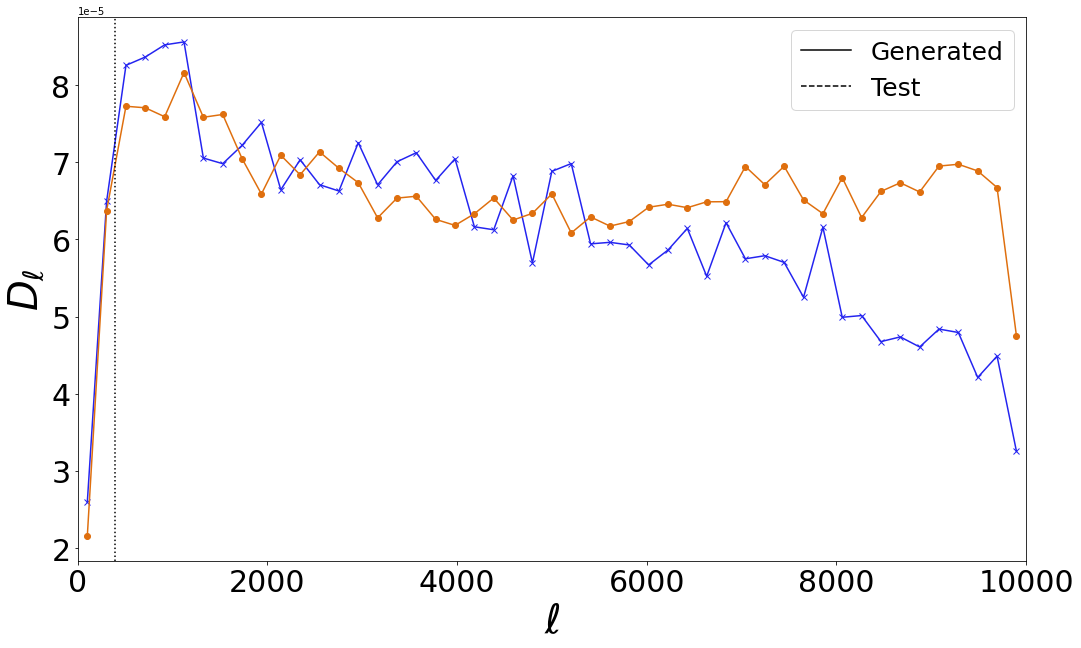

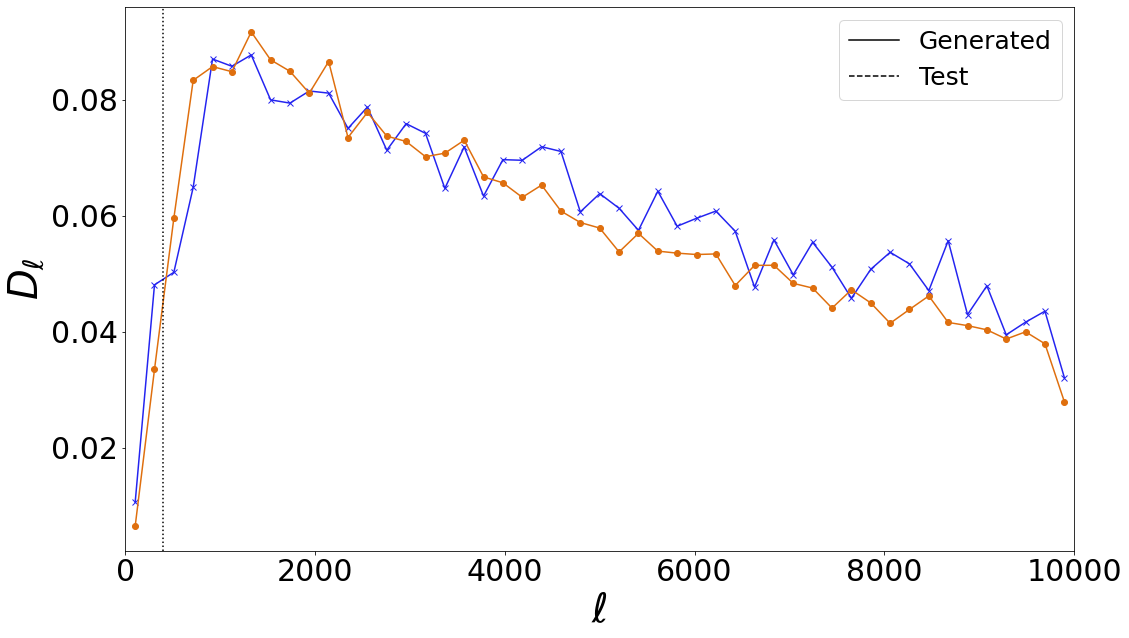

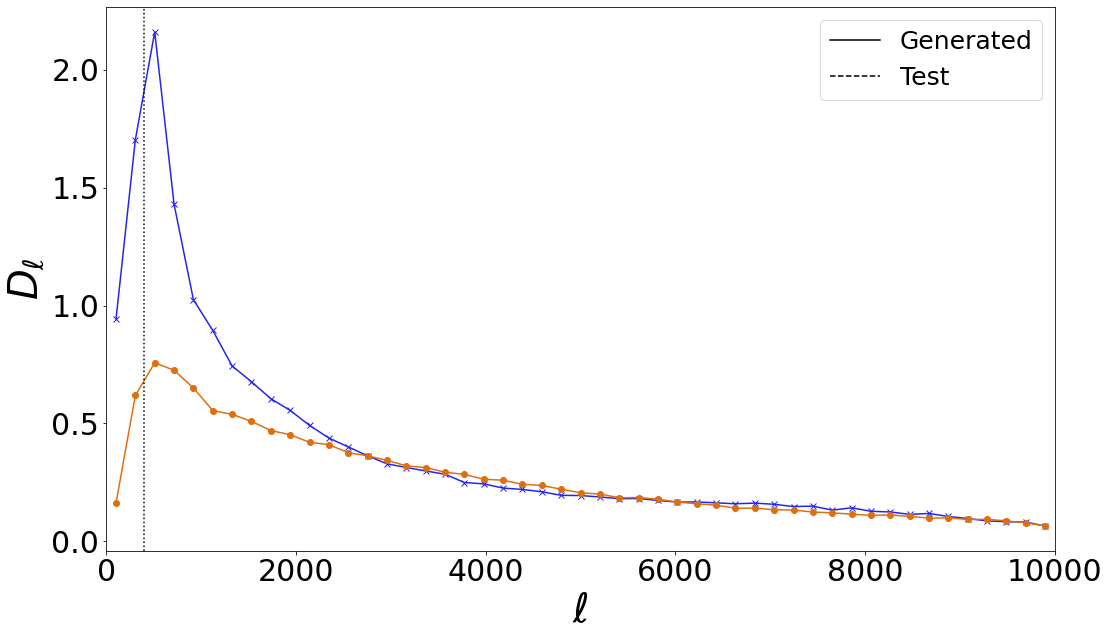

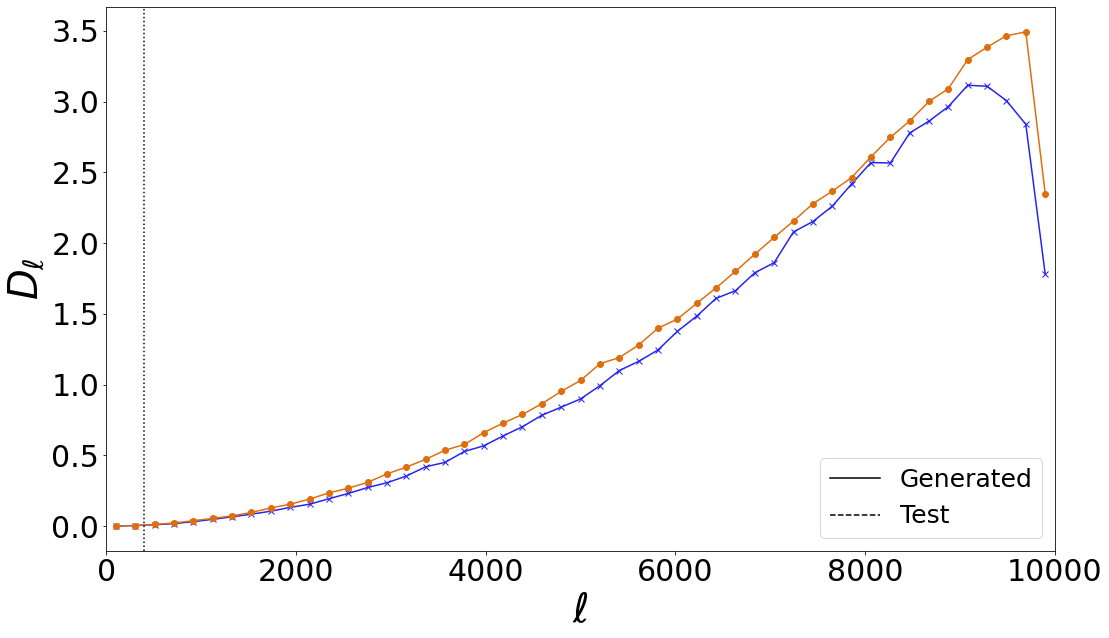

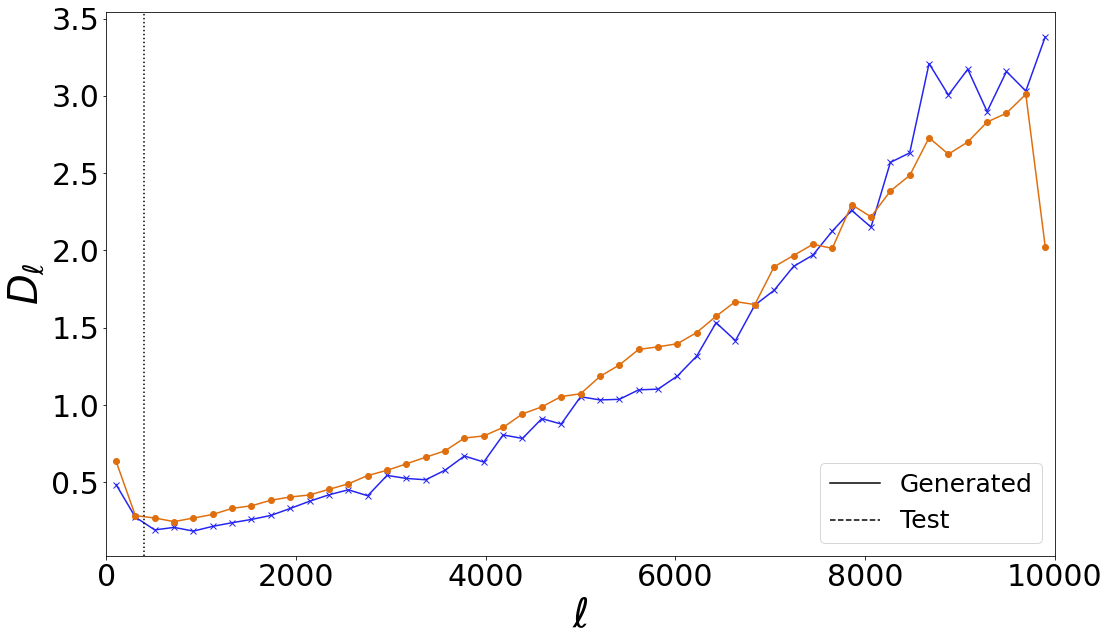

In [28]:
plt.clf()
compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for key1 in compts:
    fig = plt.figure(figsize=(17,10))
    ax = fig.gca()
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
    skey = key + "_r" + str(save_points[-1])

    dlbin_gen = STAT_GEN_CORR.stats[skey]["mean"].copy()
    std_gen = STAT_GEN_CORR.stats[skey]["std"].copy()
    #plt.plot(lbin, dlbin, std,  marker="o",markersize=8, label=skey)
    
    lbin = STAT_TEST.storage["lbin"][0].copy()
    dlbin = STAT_TEST.stats[key]["mean"].copy()
    std = STAT_TEST.stats[key]["std"].copy()
    #plt.plot(lbin,(dlbin/dlbin_gen), marker="*")
    #plt.plot(lbin, std_gen/std*(dlbin/dlbin_gen), marker="o")
    plt.plot(lbin, std_gen, marker="x")
    plt.plot(lbin, std, marker="o")
    #plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color="k", ls="--")
    #plt.plot(l, dls, alpha=0.3, label=key, ls="", marker="o", markersize=4)
    #plt.plot([],[], label=key, color=color)
    plt.plot([],[], ls="-",label="Generated", color="k")
    plt.plot([],[], ls="--",label="Test", color="k")
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$D_\ell$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.legend(fontsize=25)
    #plt.ylim(1e-7,2e3)
    plt.axvline(x=400, ls=":", color="k")
    plt.xlim(0,10000)
    #plt.yscale("log")
    plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 432x288 with 0 Axes>

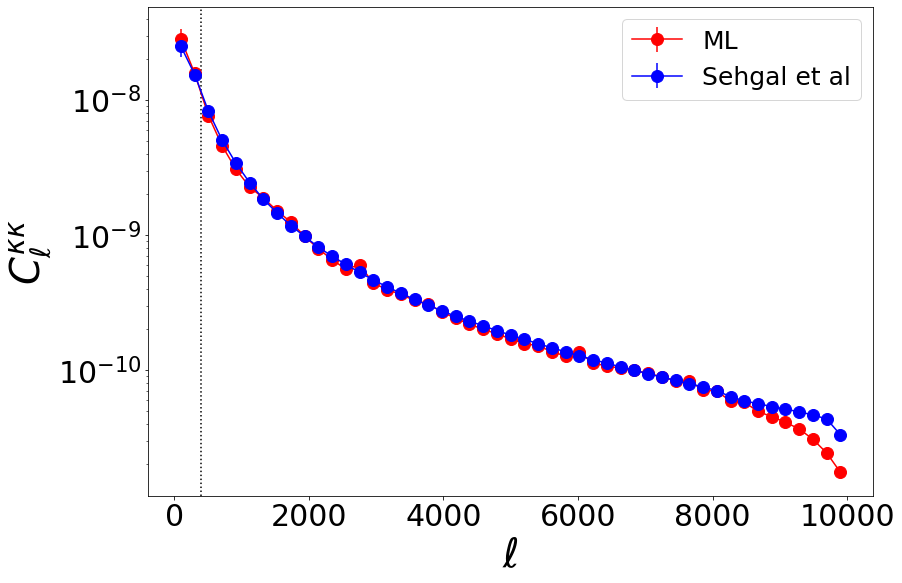

In [29]:
plt.clf()
fig = plt.figure(figsize=(13,9))
ax = fig.gca()

key = "dls_"+"kappaxkappa"
skey = key+"_r{}".format(save_points[-1])

lbin = STAT_GEN.storage["lbin"][0]
dlbin = STAT_GEN.stats[skey]["mean"]
clbin = dlbin /(lbin*(lbin+1)/2)
std = STAT_GEN.stats[skey]["std"].copy()
std /= (lbin*(lbin+1)/2)
plt.errorbar(lbin, clbin, std,  marker="o",markersize=12, color="r", label="ML")

lbin = STAT_TEST.storage["lbin"][0]
dlbin = STAT_TEST.stats[key]["mean"]
clbin = dlbin /(lbin*(lbin+1)/2)
std = STAT_TEST.stats[key]["std"].copy()
std /= (lbin*(lbin+1)/2)
\
plt.errorbar(lbin, clbin, std, marker="o",markersize=12, color="b", label="Sehgal et al")
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.ylabel(r"$C_\ell^{\kappa \kappa}$", fontsize=40)
plt.xlabel(r"$\ell$", fontsize=40)
plt.legend(fontsize=25)
#plt.ylim(1e-7,2e3)
plt.axvline(x=400, ls=":", color="k")
plt.yscale("log")
plt.show()


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 432x288 with 0 Axes>

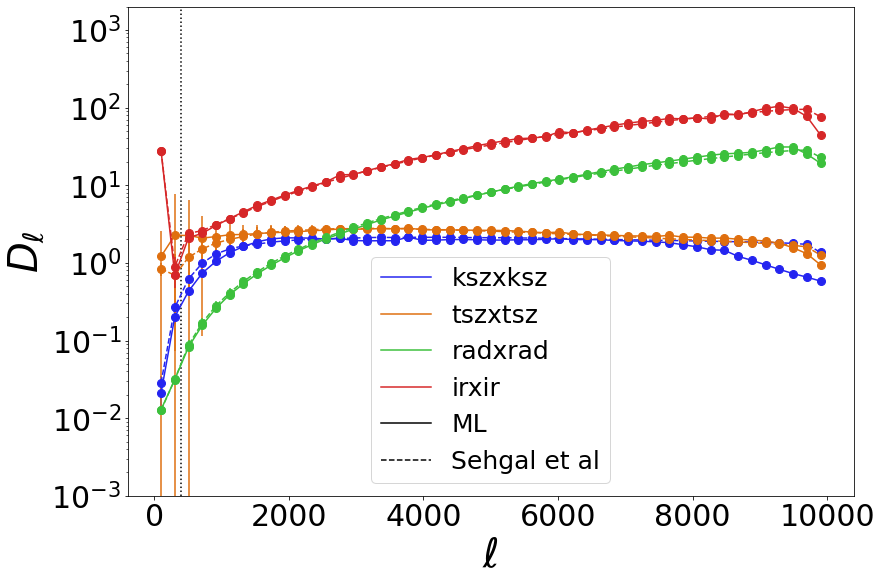

In [32]:
plt.clf()
fig = plt.figure(figsize=(13,9))
ax = fig.gca()
compts = ["ksz", "tsz", "rad", "ir"]
for key1 in compts:
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
    skey = key+"_r{}".format(save_points[-1])
    color = next(ax._get_lines.prop_cycler)['color']
    
    lbin = STAT_GEN.storage["lbin"][0]
    dlbin = STAT_GEN.stats[skey]["mean"]
    std = STAT_GEN.stats[skey]["std"]
    plt.errorbar(lbin, dlbin, std,  marker="o",markersize=8, color=color)
    
    lbin = STAT_TEST.storage["lbin"][0]
    dlbin = STAT_TEST.stats[key]["mean"]
    std = STAT_TEST.stats[key]["std"]
    plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color=color, ls="--")
    #plt.plot(l, dls, alpha=0.3, label=key, ls="", marker="o", markersize=4)
    plt.plot([],[], label=key.split("_")[-1], color=color)
plt.plot([],[], ls="-",label="ML", color="k")
plt.plot([],[], ls="--",label="Sehgal et al", color="k")
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.ylabel(r"$D_\ell$", fontsize=40)
plt.xlabel(r"$\ell$", fontsize=40)
plt.legend(fontsize=25)
plt.ylim(1e-3,2e3)
plt.axvline(x=400, ls=":", color="k")
plt.yscale("log")
plt.show()


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


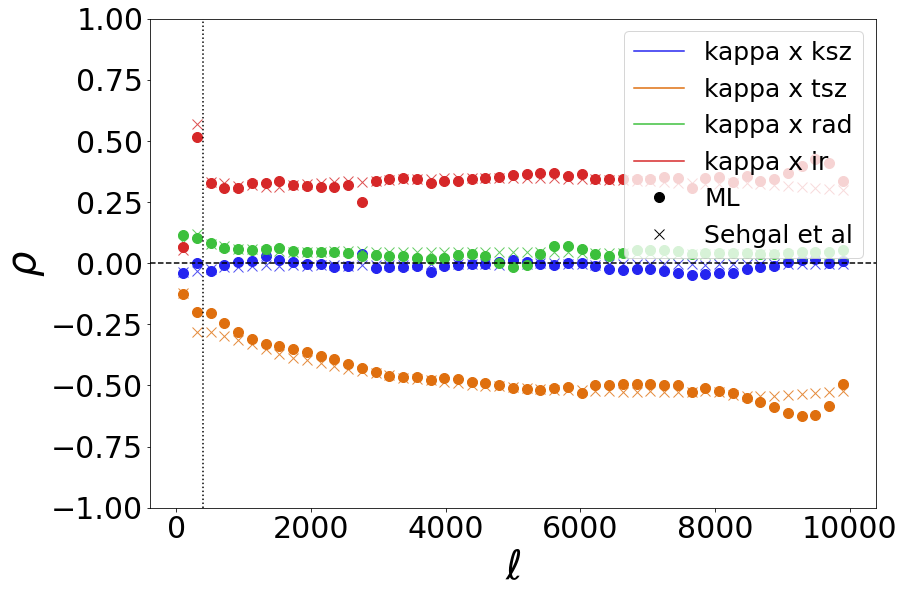

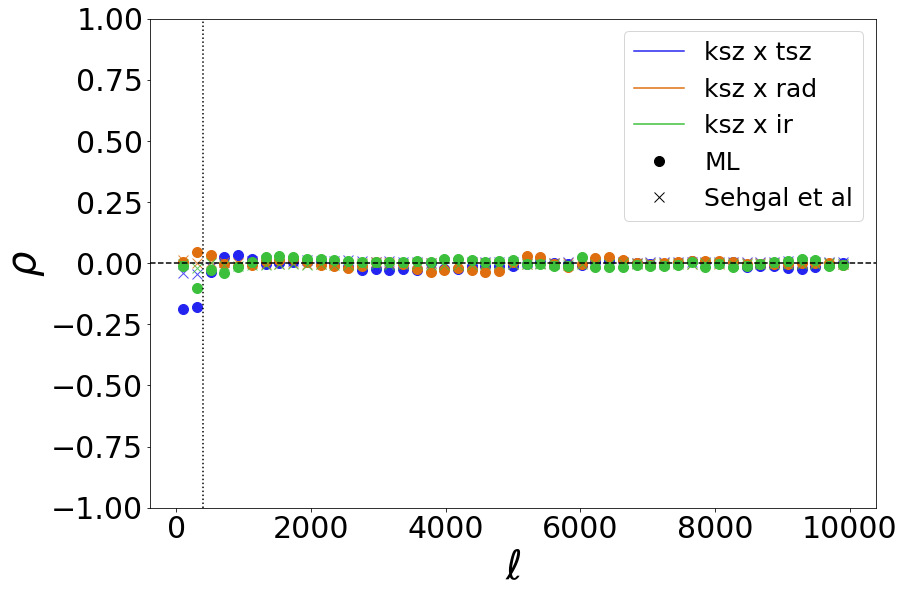

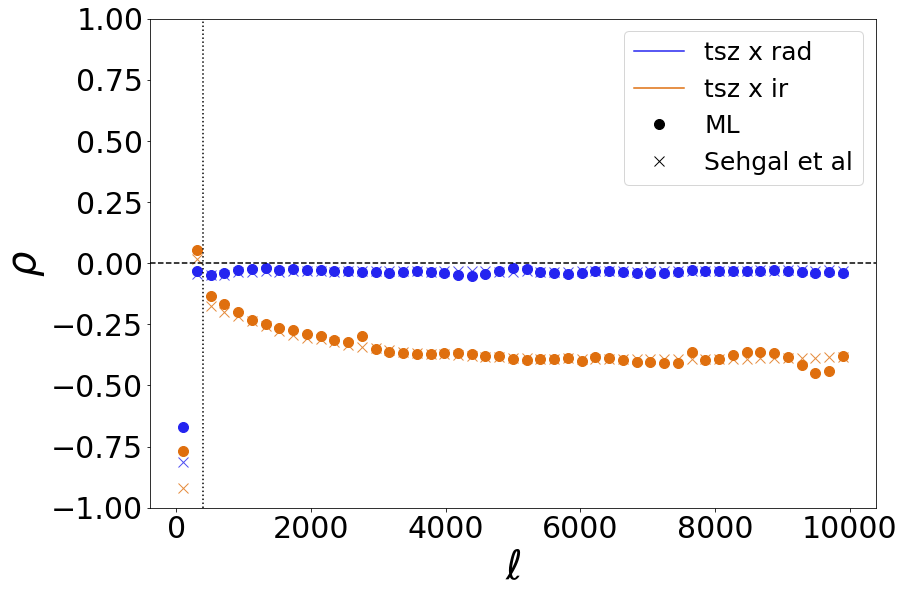

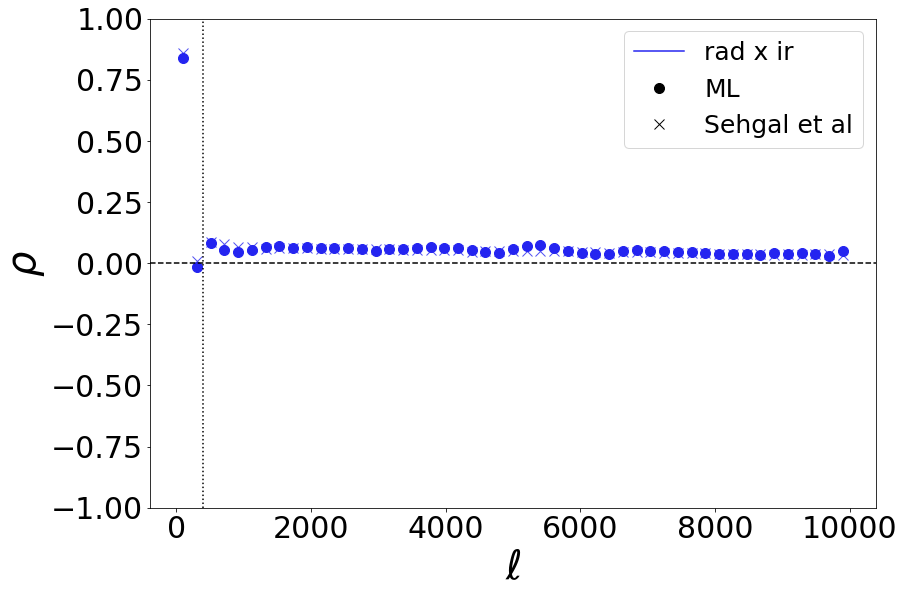

In [34]:

def get_correlation(STAT, key1, key2, postfix=""):
    key1 = compts[i]
    key2 = compts[j]
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)+postfix
    
    dls_x = STAT.stats[key]["mean"].copy()

    key = "dls_"+"x".join([key1, key1])+postfix
    dls_1 = STAT.stats[key]["mean"].copy()

    key = "dls_"+"x".join([key2, key2])+postfix
    dls_2 = STAT.stats[key]["mean"].copy()

    return dls_x/np.sqrt(dls_1*dls_2)
    

compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for i in range(5-1):
    fig = plt.figure(figsize=(13,9))
    ax = fig.gca()
    for j in range(i+1,5):
        key1, key2 = compts[i], compts[j]
        lbin = STAT_GEN.storage["lbin"][0]
        color = next(ax._get_lines.prop_cycler)['color']
        rho = get_correlation(STAT_TEST, key1, key2)
        plt.plot(lbin, rho, alpha=0.8,  ls="", marker="x", markersize=10, color=color)

        rho = get_correlation(STAT_GEN, key1, key2, "_r{}".format(save_points[-1]))
        plt.plot(lbin, rho, alpha=1,  ls="", marker="o", markersize=10, color=color)
        plt.plot([],[], label="{}".format(" x ".join([key1, key2])), color=color)
    plt.plot([],[], ls="",label="ML", color="k",  marker="o", markersize=10)
    plt.plot([],[], ls="",label="Sehgal et al", color="k",  marker="x", markersize=10)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$\rho$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.ylim(-1,1)
    plt.axvline(x=400, ls=":", color="k")
    plt.axhline(y=0, ls="--", color="k")
    plt.legend(fontsize=25, loc="upper right")
    plt.show()
        
